*Reinforcement learning (2023-2024)*
 - Monte Carlo Prediction
   - First-visit MC prediction, for estimating $V \approx \nu_\pi$
   - Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_.$
   - On-policy ﬁrst-visit MC control (for $\epsilon$-soft policies), estimates $\pi \approx \pi_.$


*Presented by: Reza Saadatyar*
*E-mail: Reza.Saadatyar92@gmail.com*

In [1]:
import time
import imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [46]:
# ================================================ Environment ========================================
def environment (all_states, all_states_j, all_actions_k, terminal_state):
    state1, state2 = all_states_j
    action1, action2 = all_actions_k                            # Plane velocity in vertical and horizontal directions
    new_state = [state1 + action1, state2 + action2]
    if np.sum(np.all(np.equal(new_state, all_states), axis=1)): # Check new state in all states
        if (new_state == terminal_state).all():
            reward = 10
        else:
            reward = -1
    else:
        new_state = all_states_j
        reward = -10
    return new_state, reward
# ================================================== Plot ==============================================
def plot(plan, all_states, all_actions, policy, start_point, Num_epochs, end_point, gamma, epsilon, type, dis, plot_gif,Q_prediction):

    FinalTimeStep =1000000
    if plot_gif:
        FinalTimeStep = plan.shape[0]*plan.shape[1]

    states = np.zeros((FinalTimeStep , 2), dtype=int)
    actions = np.zeros((FinalTimeStep , 2),  dtype=int)
    rewards = np.zeros((FinalTimeStep , 1))
    states[0,:]=start_point[0:2]
    Count = 0

    if dis:
        fig, ax = plt.subplots(figsize=(4.5,4.5))
        !mkdir Images
    filenames = []

    while 1:
        if Count > FinalTimeStep -2:
            break
        if dis:
            plan2 = np.copy(plan)
            plan2[states[Count, 0], states[Count, 1]] = 3  # 3: Change the color start state
            plan2[end_point[0], end_point[1]] = 2  # 2: Change the color terminal state
            ax.cla()
            ax.imshow(plan2, cmap='winter')
            plt.title([f"gamma:{gamma}; Time Step:{Count}; Num_epochs:{Num_epochs}; {type}"],fontsize=8)
            plt.text(start_point[1] - 0.4, start_point[0], 'Start', fontsize=10, color='r', fontweight='bold')
            plt.text(end_point[1] - 0.3, end_point[0], 'End', fontsize=10, color='r', fontweight='bold')
            display(fig)
            clear_output(wait=True)
            if Count == 0:
               time.sleep(1)
            else:
               time.sleep(0.3)

            if plot_gif:
                filename = f'Images/{Count}.png'
                filenames.append(filename)
                plt.savefig(filename, facecolor='white')

        if np.random.rand(1)>epsilon:
            Ind = policy[np.argmax(np.sum(np.equal(all_states, states[Count, :]), axis=1))]
        else:
            Ind = np.random.randint(low=0, high=all_actions.shape[0], size=1)

        if (Q_prediction==1) and (Count==0):
            actions[Count, :] = start_point[2:4]
        else:
            actions[Count, :] = all_actions[Ind, :]

        [states[Count + 1, :], rewards[Count + 1, :]] = environment(all_states, states[Count, :], actions[Count, :], end_point)  # Environment

        if (states[Count + 1, :] == end_point).all():
            if dis:
                plan2 = np.copy(plan)
                plan2[states[Count + 1, 0], states[Count + 1, 1]] = 3
                plan2[end_point[0], end_point[1]] = 2
                plt.imshow(plan2, cmap='winter')
                plt.title([f"gamma:{gamma}; Time Step:{Count}; Num_epochs:{Num_epochs}; {type}"], fontsize=8)
                if plot_gif:
                    filename = f'Images/{Count+1}.png'
                    filenames.append(filename)
                    plt.savefig(filename, facecolor='white')
            break
        Count = Count + 1

    states = np.delete(states, slice(Count + 2, states.shape[0]), 0)
    rewards = (np.delete(rewards, slice(Count + 2, rewards.shape[0]), 0)).flatten()
    actions = np.delete(actions, slice(Count + 2, actions.shape[0]), 0)

    if plot_gif:
        with imageio.get_writer(f"Images/{type}; gamma({gamma}).gif", mode='I') as writer:    # Save gif format
         for filename in filenames:
             image = imageio.v2.imread(filename)
             writer.append_data(image)

    return states, rewards, actions

Text(6.7, 8, 'End')

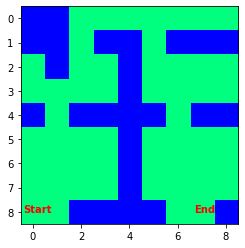

In [6]:
run_q_table = 2                 # 1, 2
if run_q_table == 1:
    plan_size = 7
    plan = np.ones((plan_size, plan_size))  # 1:free; 0: barrier
    plan[0, 1] = 0
    plan[1, [3, 4, 6]] = 0
    plan[2, [0, 1, 2, 6]] = 0
    plan[3, [4, 5]] = 0
    plan[4, [1, 2, 3]] = 0
    plan[5, 1] = 0
    plan[6, 3] = 0
    start_point = [0, 0]                       # Start point
    end_point = np.array([3, 6])               # End point
else:
    plan_size = 9
    plan = np.ones((plan_size, plan_size))  # 1:free; 0: barrier
    plan[0:2,0:2] = 0
    plan[1:9, 4] = 0
    plan[1 ,[3, 4, 6, 7, 8]] = 0
    plan[2, 1] = 0
    plan[4 ,[0, 2, 3, 4, 5, 7, 8]] = 0
    plan[8, [2,3,5, 8]] = 0
    start_point = [8, 0]                       # Start point
    end_point = np.array([8, 7])               # End point

plt.imshow(plan, cmap='winter')            # 'winter', 'prism', 'spring'
plt.text(start_point[1] - 0.4, start_point[0], 'Start', fontsize=10, color='r', fontweight='bold')
plt.text(end_point[1] - 0.3, end_point[0], 'End', fontsize=10, color='r', fontweight='bold')

In [7]:
all_states = np.array((np.where(plan.T==1)[1], np.where(plan.T==1)[0]))
all_states = all_states.T
all_actions = np.array([[1, 0],[-1, 0],[0, 1],[0, -1]])       # Down(1) Up(2) Right(3) Left(4)

**First-visit MC prediction, for estimating** $V \approx \nu_\pi$:
*Input: a policy $\pi$ to be evaluated*
*Initialize:*
   $V(s)\epsilon R$, *arbitrarily, for all* $s\epsilon S$
   *Returns(s)* $\leftarrow$ an empty list, for all $s\epsilon S$
*Loop (for each episode):*
   Generate an episode following $\pi: S_0, A_0, R_1, S_1, A_1, R_2,..., S_{T-1}, A_{T-1}, R_T$
   G$\leftarrow 0$
   *Loop for each of episode, t=T-1, T-2, ... 0:*
      $G\leftarrow \lambda G+R_{t+1}$
      *Unless $S_t$ appears in $S_0, S_1, ..., S_{t-1}:$*
         *Append G to Retuens($S_t$)*
         $V(S_{t})\leftarrow$ *average(Retuens*($S_t$))

In [11]:
# ======================================== Step 1:Initialization ========================================
gamma = 0.999
epsilon = 1
Num_epochs = 600                         # Policy evaluation
type = 'First-visit MC'

V = np.zeros((np.size(all_states, 0)))
counter = np.zeros((np.size(all_states, 0)))
policy = np.random.randint(low=0, high=all_actions.shape[0], size=all_states.shape[0])
# ====================================== Step 2:Policy Evaluation =======================================
for i in tqdm(range(0, Num_epochs), desc='Number Epochs:'):
    v = np.copy(V)
    [states, rewards, actions] = plot(plan, all_states, all_actions, policy, start_point, Num_epochs, end_point, gamma, epsilon, type, dis=0, plot_gif=0, Q_prediction=0)

    for j in range(0,np.size(all_states, 0)):
        if (all_states[j, :]==end_point).all():
            continue

        ind = np.where(np.sum(np.equal(states, all_states[j, :]),axis=1)==2)[0]
        if len(ind)==0:
            continue

        counter[j] = counter[j] +1
        first_vist = ind[0]
        Return = np.sum(rewards[first_vist+1:]*np.power(gamma, np.arange(0, len(rewards[first_vist+1:]))))
        V[j] = V[j] + (1/counter[j])*(Return - V[j])

    if np.linalg.norm(V-v) < 1e-4:
        break
# ===================================== Step 3:Policy Improvement =======================================
policy = np.zeros((np.size(all_states, 0), 1), dtype=int)   # Policy improvement: selection of the best action; Down(1) Up(2) Right(3) Left(4)
for j in range(0,np.size(all_states , 0)):
    vector = np.zeros((np.size(all_actions , 0),1))
    for k in range(0, np.size(all_actions , 0)):
        [new_state, reward] = environment (all_states, all_states[j,:], all_actions[k,:], end_point)   # Environment
        ind = np.argmax(np.sum(np.equal( all_states, new_state),axis=1))
        vector[k] = reward + gamma*V[ind]
    ind = np.where(vector==np.max(vector))[0]
    policy[j] = ind[np.random.randint(low=0, high=len(ind), size=1)]

Number Epochs:: 100%|██████████| 600/600 [01:44<00:00,  5.72it/s]


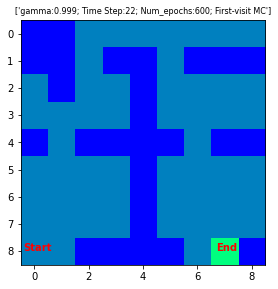

In [13]:
# ==================================== Step 4:Plot First-visit MC =======================================
dis = 1                                  # dis = 1: Show plot
epsilon = 0
plot_gif = 0                             # plot_gif = 1 : Save plots
type = 'First-visit MC'

[states, rewards, actions] = plot(plan, all_states, all_actions, policy, start_point, Num_epochs, end_point, gamma, epsilon, type, dis,  plot_gif, Q_prediction=0)

**Monte Carlo ES (Exploring Starts), for estimating** $\pi \approx \pi_.$ :
*Initialize:*
   $\pi(s)\epsilon A(s)$, *arbitrarily, for all* $s\epsilon S$
   $Q(s,a)\epsilon R$, *arbitrarily, for all* $s\epsilon S, a\epsilon A(s)$
   *Returns(s,a)* $\leftarrow$ an empty list, for all $s\epsilon S, a\epsilon A(s)$
*Loop (for each episode):*
   *Choose* $S_0\epsilon S, A_0\epsilon A(S_0)$ *randomly such that all pairs have probability > 0*
   *Generate an episode from* $S_0, A_0,$ *following* $\pi:S_0, A_0, R_1, S_1, A_1, R_2,..., S_{T-1}, A_{T-1}, R_T$
   G$\leftarrow 0$
   *Loop for each of episode, t=T-1, T-2, ... 0:*
      $G\leftarrow \lambda G+R_{t+1}$
      *Unless the pairs $S_t, A_t$ appears in $S_0, S_1, A_1, ..., S_{t-1}, A_{t-1}:$*
         *Append G to Retuens($S_t, A_t$)*
         $Q(S_t, A_t)\leftarrow$ *average(Retuens*($S_t, A_t$))
   $\pi(s) = argmax_a Q(s,a)$

In [27]:
# ======================================== Step 1:Initialization ========================================
gamma = 0.9999
epsilon = 1
Num_epochs = 700                    # Policy evaluation
Q_prediction = 1                    # 1: for Q Prediction   0: for Value Prediction
type = 'Exploring Starts'
num_action = all_actions.shape[0]
state_actionPais = np.zeros((all_states.shape[0]*all_actions.shape[0], 4), dtype=int)
policy = np.random.randint(low=0, high=all_actions.shape[0], size=all_states.shape[0])

for i in range(0, all_states.shape[0]):
    state_actionPais[num_action*i:num_action+4*i, :] = np.concatenate((np.tile(all_states[i,:],(4,1)),all_actions), axis=1)

counter = np.zeros((state_actionPais.shape[0], 1))
Q = np.zeros((state_actionPais.shape[0], 1))
# ====================================== Step 2:Policy Evaluation =======================================
for i in tqdm(range(0, Num_epochs), desc='Number Epochs:'):
    start_state = state_actionPais[np.random.randint(low=0, high=len(state_actionPais)-4,size=1), :]
    start_state = start_state.flatten()
    [states, rewards, actions] = plot(plan, all_states, all_actions, policy, start_state, Num_epochs, end_point, gamma, epsilon, type, dis=0, plot_gif=0, Q_prediction=1)

    state_action = np.concatenate((states, actions), axis=1)
    for j in range(0, len(state_actionPais)):
        if (state_actionPais[j, 0:2]==end_point).all():
            continue

        ind = np.where(np.sum(np.equal(state_action, state_actionPais[j, :]),axis=1)==4)[0]
        if len(ind)==0:
            continue

        counter[j] = counter[j] + 1
        first_vist = ind[0]
        a=rewards[first_vist+1:]
        Return = np.sum(rewards[first_vist+1:]*np.power(gamma, np.arange(0, len(rewards[first_vist+1:]))))
        Q[j] = Q[j] + (1/counter[j])*(Return - Q[j])
# ===================================== Step 3:Policy Improvement =======================================
policy = np.zeros((np.size(all_states, 0), 1), dtype=int)   # Policy improvement: selection of the best action; Down(1) Up(2) Right(3) Left(4)
for k in range(0,np.size(all_states, 0)):
    Q_ = Q[num_action*k:num_action+4*k]
    Ind = np.where(Q_==np.max(Q_))[0]
    policy[k] = Ind[np.random.randint(low=0, high=len(Ind), size=1)]

Number Epochs:: 100%|██████████| 700/700 [02:24<00:00,  4.84it/s]


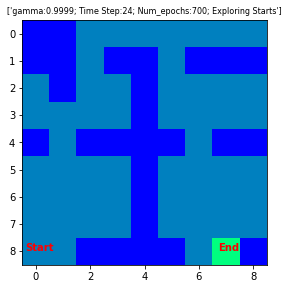

In [28]:
# ==================================== Step 4:Plot Exploring starts ======================================
dis = 1                                  # dis = 1: Show plot
epsilon = 0
plot_gif = 0                             # plot_gif = 1 : Save plots
type = 'Exploring Starts'

[states, rewards, actions] = plot(plan, all_states, all_actions, policy, start_point, Num_epochs, end_point, gamma, epsilon, type, dis,  plot_gif, Q_prediction=0)

**On-policy ﬁrst-visit MC control (for** $\epsilon-soft$ **policies), estimates** $\pi \approx \pi_.$ :
*Initialize:*
   *small* $\epsilon > 0$
   $\pi(s)\leftarrow$ *arbitrarily* $\epsilon-soft$ *policy*
   $Q(s,a)\epsilon R$ *arbitrarily, for all* $s\epsilon S, a\epsilon A(s)$
   *Returns(s,a)* $\leftarrow$ *empty list, for all* $s\epsilon S, a\epsilon A(s)$
*Loop (for each episode):*
   *Generate an episode following* $\pi:S_0, A_0, R_1, S_1, A_1, R_2,..., S_{T-1}, A_{T-1}, R_T$
   G$\leftarrow 0$
   *Loop for each of episode, t=T-1, T-2, ... 0:*
      $G\leftarrow \lambda G+R_{t+1}$
      *Unless the pairs $S_t, A_t$ appears in $S_0, S_1, A_1, ..., S_{t-1}, A_{t-1}:$*
         *Append G to Retuens($S_t, A_t$)*
         $Q(S_t, A_t)\leftarrow$ *average(Retuens*($S_t, A_t$))
         $A^.\leftarrow argmax_a Q(S_t, a)$
         *For all* $a \epsilon A(S_t):$
         $\pi(a|S_t)\leftarrow 1-\epsilon+\epsilon+\epsilon/|A(S_t)|$ *if* $a=A^.$  *or* $\epsilon/|A(S_t)|$ *if* $a\neq A^.$

In [44]:
# ======================================== Step 1:Initialization ========================================
gamma = 0.99
epsilon = 0.98
Num_epochs = 200                    # Policy evaluation
num_action = all_actions.shape[0]
state_actionPais = np.zeros((all_states.shape[0] * all_actions.shape[0], 4), dtype=int)
policy = np.random.randint(low=0, high=all_actions.shape[0], size=all_states.shape[0])

for i in range(0, all_states.shape[0]):
    state_actionPais[num_action * i:num_action + 4 * i, :] = np.concatenate((np.tile(all_states[i, :], (4, 1)), all_actions), axis=1)

counter = np.zeros((state_actionPais.shape[0], 1))
Q = np.zeros((state_actionPais.shape[0], 1))
# ====================================== Step 2:Policy Evaluation =======================================
for i in tqdm(range(0, Num_epochs), desc='Number Epochs:'):
    start_state = state_actionPais[np.random.randint(low=0, high=len(state_actionPais)-4,size=1), :]
    start_state = start_state.flatten()
    [states, rewards, actions] = plot(plan, all_states, all_actions, policy, start_state, Num_epochs, end_point, gamma, epsilon, type, dis=0, plot_gif=0, Q_prediction=1)

    state_action = np.concatenate((states, actions), axis=1)
    for j in range(0, len(state_actionPais)):
        if (state_actionPais[j, 0:2]==end_point).all():
            continue

        ind = np.where(np.sum(np.equal(state_action, state_actionPais[j, :]),axis=1)==4)[0]
        if len(ind)==0:
            continue

        counter[j] = counter[j] + 1
        first_vist = ind[0]
        Return = np.sum(rewards[first_vist+1:]*np.power(gamma, np.arange(0, len(rewards[first_vist+1:]))))
        Q[j] = Q[j] + (1/counter[j])*(Return - Q[j])
# ===================================== Step 3:Policy Improvement =======================================
    policy = np.zeros((np.size(all_states, 0), 1), dtype=int)   # selection of the best action; Down(1) Up(2) Right(3) Left(4)
    for k in range(0,np.size(all_states, 0)):
        Q_ = Q[num_action*k:num_action+4*k]
        Ind = np.where(Q_==np.max(Q_))[0]
        policy[k] = Ind[np.random.randint(low=0, high=len(Ind), size=1)]

    epsilon = epsilon *0.97

Number Epochs:: 100%|██████████| 200/200 [00:10<00:00, 18.99it/s] 


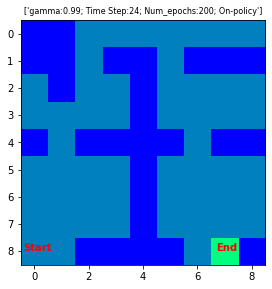

In [45]:
# ======================================== Step 4:Plot On-policy =========================================
dis = 1                                  # dis = 1: Show plot
epsilon = 0
plot_gif = 0                             # plot_gif = 1 : Save plots
type = 'On-policy'
[states, rewards, actions] = plot(plan, all_states, all_actions, policy, start_point, Num_epochs, end_point, gamma, epsilon, type, dis,  plot_gif, Q_prediction=0)